<style>
ul, ol {
    margin-top: 0.3em;
    margin-bottom: 0.3em;
}
li {
    line-height: 1.1em;
}
</style>


\begin{center}
\textbf{Individual Household Electric Power Consumption Forecasting}\\[2pt]
TFgirls (Wei Li, Yujia Wang)
\end{center}

# Introduction

## Decisions to be impacted
Accurate electricity consumption forecasting supports critical decision-making for energy providers, grid operators, and policymakers. 
By predicting future demand, it enables efficient power generation planning, load balancing, and infrastructure management. 
Short-term forecasts assist in operational scheduling and preventing blackouts, while long-term predictions guide investment 
and capacity planning.

## Business and Societal Value
1. Better planning of generation can save money and reduce unnecessary fuel use.
2. A stable and reliable grid means fewer outages and better service for households.
3. Forecasting can also support the integration of renewable energy, since solar and wind are variable and 
need better planning to be used effectively.

## The reason we care about this project
This project is highly relevant to our daily lives since electricity is something everyone depends on every day. 
Combining electricity consumption forecasting with data analytics allows us to address practical problems in an efficient and intelligent 
way. Through our Data Mining and Machine Learning courses, we have learned various data processing techniques and predictive models that 
can be  effectively applied in this project. It connects what we have learned in class with real-world market needs, making it both 
academically valuable and practically meaningful. It feels meaningful because it bridges our coursework with issues like energy efficiency 
and sustainability that affect everyone.

# Data  and Data Preprocessing

## Data Description

The **Household Power Consumption Dataset** records one household’s electrical usage at **one-minute intervals** between **December 2006 and November 2010**, totaling over **2 million observations** across nine variables.

**Variable definitions:**

1. **Date** — date in format `dd/mm/yyyy`  
2. **Time** — time in format `hh:mm:ss`  
3. **Global_active_power (kW)** — household global minute-averaged active power, representing the total real energy consumed by the household  
4. **Global_reactive_power (kVAR)** — household global minute-averaged reactive power, associated with phase difference between voltage and current  
5. **Voltage (V)** — minute-averaged supply voltage, typically around 230 volts  
6. **Global_intensity (A)** — household global minute-averaged current intensity  
7. **Sub_metering_1 (Wh/min)** — energy sub-meter No.1, corresponding to the **kitchen**, mainly including a dishwasher, oven, and microwave (hot plates are gas-powered)  
8. **Sub_metering_2 (Wh/min)** — energy sub-meter No.2, corresponding to the **laundry room**, including a washing machine, tumble dryer, refrigerator, and lighting  
9. **Sub_metering_3 (Wh/min)** — energy sub-meter No.3, corresponding to **heating and air-conditioning systems**, including an electric water heater and an air conditioner  

This dataset provides detailed insight into both **global household energy consumption** and **appliance-level usage patterns**, enabling fine-grained time series analysis of daily, weekly, and seasonal consumption behavior.

## Data Import and Summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load raw dataset
data_raw = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    header=0,
    low_memory=False,
)

In [3]:
# Summary of Dataset
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


In [4]:
print(data_raw.head())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


We examined the structure and data types of the dataset and found that most variables are stored as object types, except for Sub_metering_3. This indicates that the data are currently read as strings, so we will later convert these columns into float types to enable numerical analysis and modeling.

##  Data Cleaning

### Build Datetime Index
The dataset originally separates **Date** and **Time** columns.  
We combine them into a single **datetime index**, drop invalid entries, and sort chronologically.  
This ensures a continuous and correctly ordered time series, which is essential for resampling and time-based analysis.

In [5]:
# Build datetime index
# Combine 'Date' + 'Time' into one datetime column
data_raw['datetime'] = pd.to_datetime(
    data_raw['Date'] + ' ' + data_raw['Time'],
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce'
)

# Drop invalid datetimes and sort
data = data_raw.dropna(subset=['datetime']).sort_values('datetime')
data = data.set_index('datetime').drop(columns=['Date', 'Time'])

print("Datetime range:", data.index.min(), "→", data.index.max())
print("Total valid rows:", len(data))

Datetime range: 2006-12-16 17:24:00 → 2010-11-26 21:02:00
Total valid rows: 2075259


### Data Type Conversion
We examined the dataset structure and found that most variables are of type `object`, requiring conversion to `float` for numerical analysis.

In [6]:
# Convert numeric columns from object to float
num_cols = [
    'Global_active_power','Global_reactive_power','Voltage','Global_intensity',
    'Sub_metering_1','Sub_metering_2','Sub_metering_3'
]

for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

print("Numeric conversion complete. Sample values:\n", data[num_cols].head(3))

Numeric conversion complete. Sample values:
                      Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   

                     Sub_metering_3  
datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  


### Handle Timestamp and Missing Values

Before analyzing the dataset, it is crucial to ensure that the **time index is continuous and clean**,  since irregular timestamps or missing intervals can distort trend and seasonality analysis.

1. Duplicate Timestamp Check  
We first check and remove **duplicate timestamps** to guarantee that each minute has only one valid record.

2. Reindex to Continuous 1-Minute Frequency  
The dataset is then reindexed to a strict **1-minute frequency (`asfreq('min')`)**, so even missing timestamps are explicitly represented (filled with `NaN`).

3. Identify Missing Values  
We count missing numeric entries before interpolation to understand the scale of data gaps.

4. Time-Based Interpolation  
Missing values are filled using **time interpolation**, which leverages temporal continuity — ensuring smoother transitions and preventing abrupt jumps in the time series.  
The `limit_direction='both'` option fills gaps in both forward and backward directions.

5. Validation  
Finally, we re-check all variables to confirm that **no missing values remain** after interpolation.

This step ensures that our dataset is **temporally consistent**, ready for accurate resampling, outlier detection, and subsequent modeling.

In [7]:
# Check for duplicate timestamps and enforce 1-minute frequency
dup_count = data.index.duplicated().sum()
if dup_count > 0:
    print("Duplicate timestamps found:", dup_count)
    data = data[~data.index.duplicated(keep='first')]

# Reindex to continuous 1-min frequency
data = data.asfreq('min')

# check missing values before interpolation
missing_before = data[num_cols].isna().sum().sum()
print("Total missing values BEFORE interpolation:", missing_before)

# fill missing values using time interpolation
data[num_cols] = data[num_cols].interpolate(method='time', limit_direction='both')

# confirm no missing values remain
missing_after = data[num_cols].isna().sum().sum()
print("Total missing values AFTER interpolation:", missing_after)

Total missing values BEFORE interpolation: 181853
Total missing values AFTER interpolation: 0


### Outlier Detection 

**Define Physical Limits:**

The upper and lower bounds (`bounds`) used in outlier clipping are **not arbitrary**, but are based on **physical constraints of residential electrical systems**.  

For example:

- **Global_active_power (0–6 kW)** — typical household total power rarely exceeds 6 kW  
- **Global_reactive_power (-0.5–0.5 kVAR)** — reactive power caused by voltage/current phase difference, usually very small  
- **Voltage (200–250 V)** — around 230 V ±10%, following European household grid standards  
- **Global_intensity (0–25 A)** — approximately equivalent to 6 kW / 240 V  
- **Sub_metering_1–3** — correspond to circuits for kitchen, laundry, and HVAC systems; ranges defined by rated appliance power  

Hence, the bounds here represent **physical validity ranges** rather than arbitrary statistical thresholds.  
We are not deleting data points, but **restricting unrealistic readings** to remain within reasonable physical limits.

In [8]:
# Outlier detection: clip to physical limits
# define physical limits
bounds = {
    'Global_active_power': (0,6),        # kW
    'Global_reactive_power': (-0.5,0.5), # kVAR
    'Voltage': (200,250),                # V
    'Global_intensity': (0,25),          # A
    'Sub_metering_1': (0,60),            # Wh/min
    'Sub_metering_2': (0,50),            # Wh/min
    'Sub_metering_3': (0,45)             # Wh/min
}

# before clipping: proportion of out-of-range values
extreme_stats_before = []
for var,(lo,hi) in bounds.items():
    s = data[var]
    below = (s<lo).mean()*100
    above = (s>hi).mean()*100
    extreme_stats_before.append([var,round(below,4),round(above,4),round(below+above,4)])
print("Out-of-range ratio BEFORE clipping (%):")
print(pd.DataFrame(extreme_stats_before,columns=['Variable','Below_%','Above_%','Total_%']))

# apply clipping
for var,(lo,hi) in bounds.items():
    data[var] = data[var].clip(lower=lo,upper=hi)

# check after clipping: no outliers remain
extreme_stats_after = []
for var,(lo,hi) in bounds.items():
    s = data[var]
    below = (s<lo).mean()*100
    above = (s>hi).mean()*100
    extreme_stats_after.append([var,round(below,4),round(above,4),round(below+above,4)])

print("\nOut-of-range ratio AFTER clipping (%):")
print(pd.DataFrame(extreme_stats_after,columns=['Variable','Below_%','Above_%','Total_%']))

Out-of-range ratio BEFORE clipping (%):
                Variable  Below_%  Above_%  Total_%
0    Global_active_power      0.0   0.2635   0.2635
1  Global_reactive_power      0.0   0.7710   0.7710
2                Voltage      0.0   0.1932   0.1932
3       Global_intensity      0.0   0.3069   0.3069
4         Sub_metering_1      0.0   0.0317   0.0317
5         Sub_metering_2      0.0   0.1999   0.1999
6         Sub_metering_3      0.0   0.0000   0.0000

Out-of-range ratio AFTER clipping (%):
                Variable  Below_%  Above_%  Total_%
0    Global_active_power      0.0      0.0      0.0
1  Global_reactive_power      0.0      0.0      0.0
2                Voltage      0.0      0.0      0.0
3       Global_intensity      0.0      0.0      0.0
4         Sub_metering_1      0.0      0.0      0.0
5         Sub_metering_2      0.0      0.0      0.0
6         Sub_metering_3      0.0      0.0      0.0


We conducted an out-of-range value check for the main variables.  
Before clipping, a few variables such as `Global_reactive_power` and `Global_intensity` contained minor out-of-range values, with the highest ratio around **0.77%**.  
After applying clipping based on physical limits and device power ratings, all variables show **0%** out-of-range values.  
This indicates that abnormal readings have been successfully corrected, and **the overall data quality is good**, making the dataset suitable for further analysis and modeling.

### Consistency Check between Total and Sub-Metering Power

In [9]:
# Consistency check: total vs sub-metering sum
# Convert Sub_metering (Wh/min) → kW equivalent and compare with total active power
subs_kw = (data[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].sum(axis=1) * 60 / 1000)
total_kw = data['Global_active_power']
gap = subs_kw - total_kw

tolerance = 0.1  # 0.1 kW tolerance for measurement offset
violation = gap > tolerance

print("\nConsistency check (Σ Sub_metering vs Total Active Power):")
print("  Violation ratio:", round(violation.mean()*100, 4), "%")
print("  Mean excess (kW):", round(gap[violation].mean(), 4))
print("  95th percentile excess:", round(gap[violation].quantile(0.95), 4))
print("  Max excess:", round(gap.max(), 4))


Consistency check (Σ Sub_metering vs Total Active Power):
  Violation ratio: 0.0133 %
  Mean excess (kW): 0.2623
  95th percentile excess: 0.72
  Max excess: 1.08


We performed a consistency check between the total active power (Global_active_power) and the sum of the three sub-metering readings (Sub_metering_1, Sub_metering_2, Sub_metering_3).  
The results show that the violation ratio (exceeding the 0.1 kW tolerance) is only **0.013%**, with a mean excess of 0.26 W, a 95th-percentile excess of 0.72 kW, and a maximum excess of 1.08 kW.  
Since these discrepancies are minimal and within an acceptable measurement tolerance, we decided **not to modify the dataset**.

### Resample to Hourly Level

The original dataset records power consumption **every minute**, resulting in more than **2 million observations**.  
To make the data more manageable and suitable for long-term trend analysis and forecasting, we aggregate it to an **hourly level** using appropriate statistical methods for each variable.

- **Global_active_power, Global_reactive_power, Voltage, Global_intensity → mean**  
  These variables represent *instantaneous or averaged power/voltage/current* values, so their hourly average preserves the typical system behavior over time.

- **Sub_metering_1, Sub_metering_2, Sub_metering_3 → sum**  
  These sub-metering variables record *energy consumption per minute (Wh/min)*, so summing them over 60 minutes gives the **total hourly energy usage**.

Additionally, we compute:  
- **energy_kwh = Global_active_power × 1 hour / 60**  
  which converts the total active power into **kilowatt-hour (kWh)** — the standard unit of household energy consumption.

This transformation enables us to:
- reduce data volume and noise,  
- capture meaningful hourly usage patterns,  
- and align with typical electricity billing and forecasting timeframes.

In [10]:
# Resample to hourly level
hourly = data.resample('h').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

# Compute total hourly energy consumption (kWh)
hourly['energy_kwh'] = data['Global_active_power'].resample('h').sum() / 60.0

print(hourly.head())

                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.147000               0.225889  234.643889   
2006-12-16 18:00:00             3.604567               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00         17.705556             0.0            19.0   
2006-12-16 18:00:00         15.410000             0.0           403.0   
2006-12-16 19:00:00         14.503333             0.0            86.0   
2006-12-16 20:00:00         13.916667             0.0             0.0   
2006-12-

In [11]:
# hourly.to_csv('household_power_hourly.csv')

## Descriptive Statistics and Visualization

### Descriptive Statistics

In [12]:
# Descriptive Statistics and Visualization
desc = hourly.describe().T[['mean', 'std', 'min', 'max']]
print(desc)

                             mean         std         min          max
Global_active_power      1.088267    0.887020    0.124000     5.907400
Global_reactive_power    0.122911    0.064919    0.000000     0.500000
Voltage                240.831019    2.996657  225.834500   250.000000
Global_intensity         4.610997    3.705283    0.503333    24.720000
Sub_metering_1          66.315953  209.309114    0.000000  2727.000000
Sub_metering_2          75.075935  237.033794    0.000000  2422.000000
Sub_metering_3         386.528044  440.441605    0.000000  1471.470054
energy_kwh               1.088193    0.886917    0.046733     5.907400


We calculated summary statistics for the main electrical and energy variables, including the mean, standard deviation, minimum, and maximum values.  
All variables fall within reasonable ranges without extreme outliers, indicating that the dataset is clean and consistent.

### Distribution of Key Variables

We plotted the distributions of key variables such as `Global_active_power`, `Global_reactive_power`, `Voltage`, `Global_intensity`, and `energy_kwh`.  
Most variables show **right-skewed distributions**, meaning household consumption is usually at low load, with occasional high peaks.

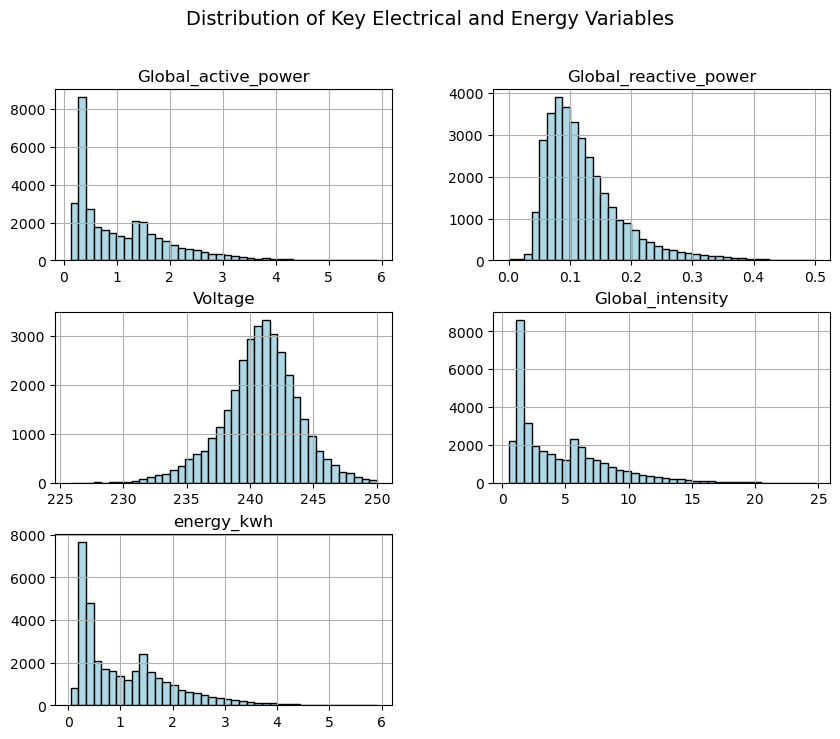

In [13]:
# distribution of key variables including energy consumption
hourly[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','energy_kwh']].hist(
    bins=40, figsize=(10,8), layout=(3,2), color='lightblue', edgecolor='black'
)
plt.suptitle('Distribution of Key Electrical and Energy Variables', fontsize=14)
plt.show()
# right-skewed distributions, most values at low load and low hourly energy

### Daily Energy Consumption Trend

We visualized the **daily total household energy consumption** based on `energy_kwh`.  
The daily trend fluctuates considerably and displays potential seasonal effects, which is expected in real household electricity usage.

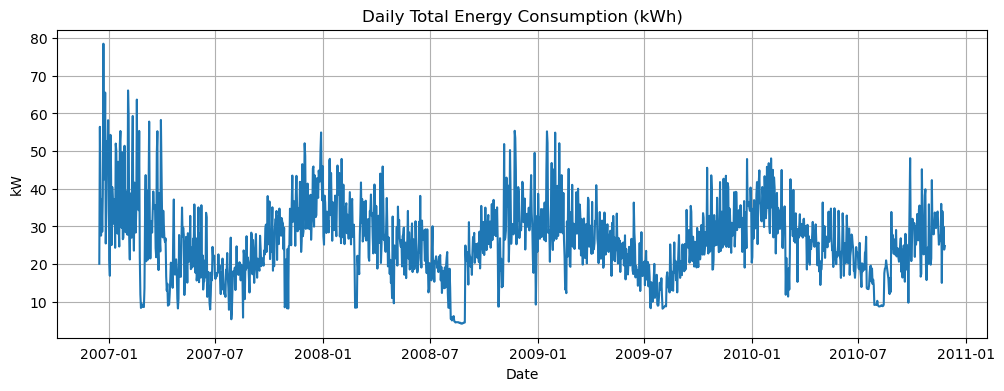

In [14]:
import matplotlib.pyplot as plt

# daily trend of global active power
plt.figure(figsize=(12,4))
plt.plot(hourly['energy_kwh'].resample('D').sum())
plt.title('Daily Total Energy Consumption (kWh)')
plt.ylabel('kWh')
plt.xlabel('Date')
plt.ylabel('kW')
plt.grid(True)
plt.show()
# shows daily total household energy use

### Monthly Average Energy Consumption

We analyzed the **monthly average household energy consumption**, which shows **cyclical variations** — higher usage in winter and summer, and lower in spring and fall.  
This confirms that the data patterns are realistic, and **the overall data quality is good for further modeling**.

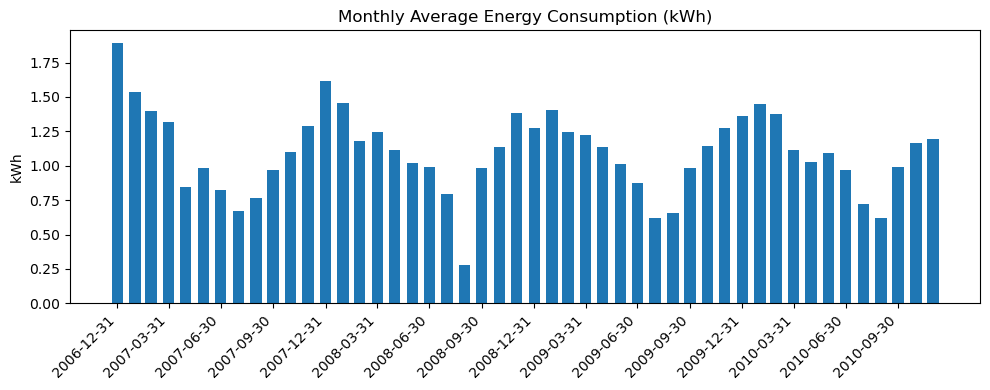

In [15]:
# monthly average energy consumption with cleaner x-axis
plt.figure(figsize=(10,4))
monthly = hourly['energy_kwh'].resample('ME').mean()

plt.bar(monthly.index, monthly.values, width=20)
plt.title('Monthly Average Energy Consumption (kWh)')
plt.ylabel('kWh')

plt.xticks(monthly.index[::3], rotation=45, ha='right')
plt.tight_layout()
plt.show()
# cleaner monthly energy trend with quarterly ticks

### Average Hourly Energy Pattern by Weekday

We analyzed the average hourly energy consumption across different weekdays.  
The pattern shows two main peaks — one in the **morning (around 7–9 AM)** and another in the **evening (around 7–9 PM)**, corresponding to typical household activity hours.  
Weekend consumption, especially on **Sunday**, is slightly higher and more evenly distributed during the day, reflecting longer home occupancy.  
This pattern aligns with daily routines and indicates consistent weekday behavior.

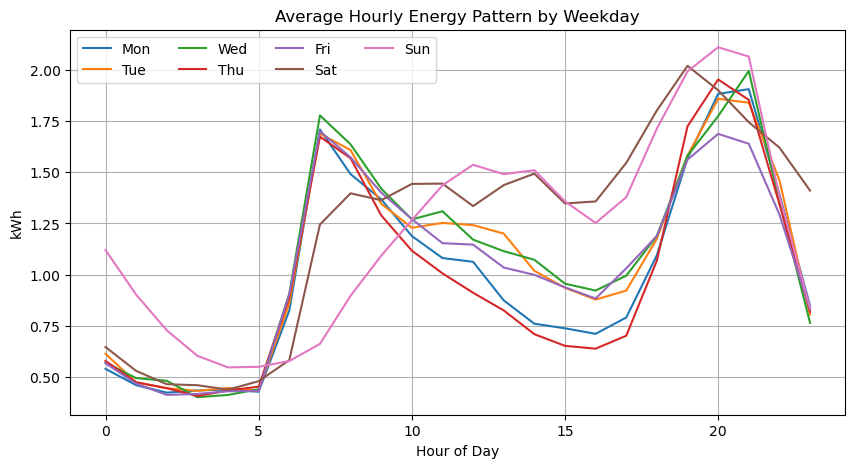

In [16]:
# average hourly energy pattern by weekday
hourly['weekday'] = hourly.index.dayofweek
hourly['hour'] = hourly.index.hour
pattern = hourly.groupby(['weekday','hour'])['energy_kwh'].mean().unstack(0)

plt.figure(figsize=(10,5))
plt.plot(pattern)
plt.legend(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], ncol=4)
plt.title('Average Hourly Energy Pattern by Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('kWh')
plt.grid(True)
plt.show()
# shows daily load pattern across weekdays

### Average Sub-Metering Energy Share

We calculated the average energy share of the three sub-metering measurements.  
The pie chart shows that **Sub_metering_3** dominates the total energy use, accounting for about **73%**, while **Sub_metering_1** and **Sub_metering_2** contribute **12.6%** and **14.2%**, respectively.  
This suggests that Sub_metering_3 is likely associated with major appliances such as **heating or AC load**.

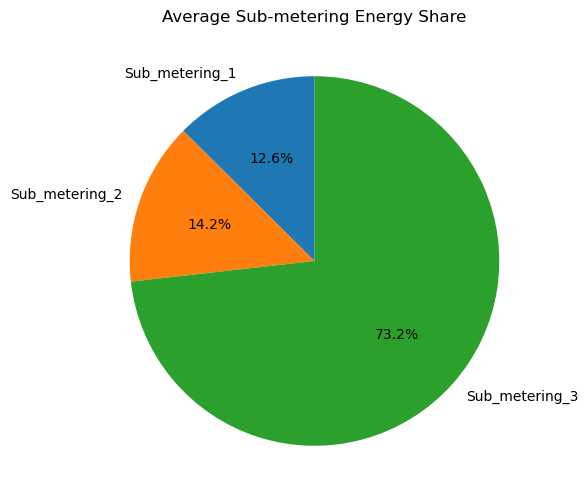

In [17]:
# average energy share by sub-metering
sub_means = hourly[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
plt.figure(figsize=(6,6))
plt.pie(sub_means, labels=sub_means.index, autopct='%1.1f%%', startangle=90)
plt.title('Average Sub-metering Energy Share')
plt.show()
# sub_metering_3 dominates, linked to heating/AC load

### Correlation Heatmap of Key Variables

We computed and visualized the correlation matrix among major electrical variables.  
`Global_active_power` shows strong positive correlations with `Global_intensity` and `Sub_metering_3`, indicating that higher total power usage is closely tied to increased current and high-load appliances.  
In contrast, `Voltage` exhibits weak or negative correlations with most variables, suggesting that it varies independently from total consumption.  
Overall, the relationships appear physically consistent and support further modeling.

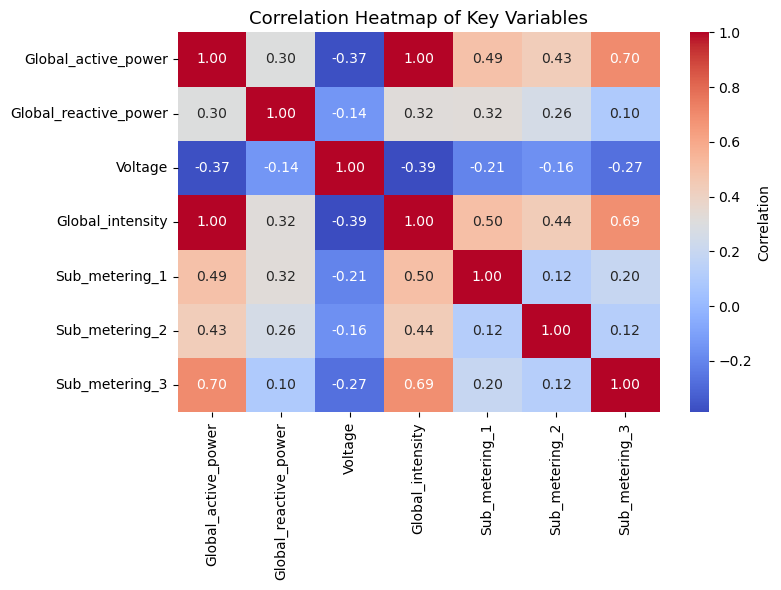

In [18]:
import seaborn as sns

corr = hourly[['Global_active_power','Global_reactive_power','Voltage',
               'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap of Key Variables', fontsize=13)
plt.tight_layout()
plt.show()
# shows relationships among main electrical variables

#  Model Updates

## SARIMA-Time series model

### Target

**Goal:**  
Predicting the pace of power consumption changes.  
**SARIMA** is a statistical model used for real-time monitoring and dispatching of energy patterns.


### Important Parameters

| Parameter | Description |
|:-----------|:-------------|
| **p, d, q** | Non-seasonal components (AR, differencing, MA) |
| **P, D, Q, m** | Seasonal components (seasonal AR, differencing, MA, and seasonal period) |


### Modeling Strategy

- Apply **first-order differencing** to remove the overall trend.  
- Include one **autoregressive term (AR(1))** and one **moving average term (MA(1))**.  
- Treat every **24 time steps** as one seasonal period (representing a **daily cycle**).  
- Apply one **seasonal differencing** to eliminate daily seasonality.  
- Use one **seasonal AR** and one **seasonal MA** term to capture short-term correlations.

missing values: 0
SARIMA → MAE=0.8129  RMSE=0.9995


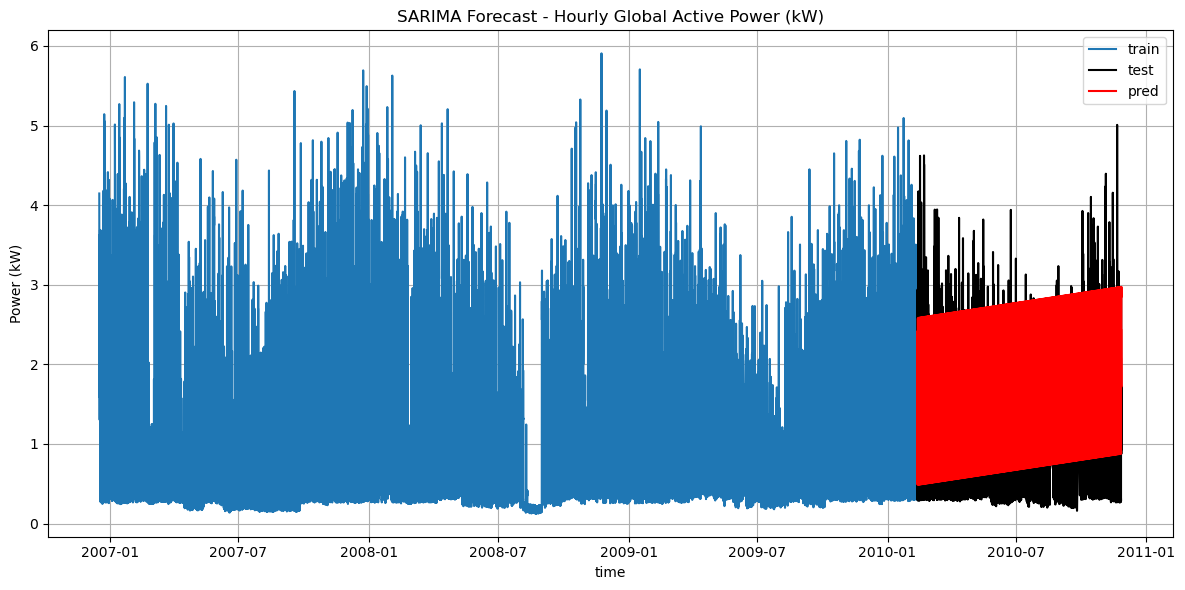

In [28]:
# SARIMA on hourly Global_active_power (uses cleaned 'hourly' df)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# target (already cleaned)
y = hourly['Global_active_power'].asfreq('h') 
print("missing values:", y.isna().sum())

# train/test split (80/20)
split = int(len(y)*0.8)
y_train, y_test = y.iloc[:split], y.iloc[split:]

# fit SARIMA (daily seasonality=24)
model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,24),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# predict on test range
y_pred = res.predict(start=y_test.index[0], end=y_test.index[-1])

# metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"SARIMA → MAE={mae:.4f}  RMSE={rmse:.4f}")

# plot
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='train')
plt.plot(y_test.index,  y_test,  label='test', color='black')
plt.plot(y_pred.index,  y_pred,  label='pred', color='red')
plt.title('SARIMA Forecast - Hourly Global Active Power (kW)')
plt.xlabel('time'); plt.ylabel('Power (kW)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

### Model Evaluation Summary

The entire power series demonstrates distinct cyclical fluctuations over a four-year period, particularly with noticeable **daily and weekly repeating patterns**.  
Overall power consumption ranges between **0 and 5 kW**, indicating significant intra-day variations with evident **morning and evening peaks**.  
There are also distinct gaps and sudden drops in the data, which may correspond to **power outages**, **missing records**, or **periods when the household was unoccupied**.

### Evaluation Metrics
| Metric | Value | Interpretation |
|:--------|:-------:|:----------------|
| MAE | **0.81 kW** | Average prediction error per time step |
| RMSE | **1.00 kW** | Overall deviation including outliers |

### How to Improve the Model Performance

To improve model performance, we plan to adjust the **ARIMA parameters** *(p, d, q)* and the **seasonal components** *(P, D, Q, m)*.  
The optimal combination of these parameters will be selected automatically based on **AIC** and **BIC** criteria.  
We plan to adopt this approach in the **next stage of our research** to enhance predictive accuracy.

## XGBoost Model

### Algorithm Description
**XGBoost** (Extreme Gradient Boosting) employs an iterative process of constructing decision trees and assessing the impact of each feature on the model’s predictive accuracy.  
This approach is highly effective for identifying the **most important and relevant features** in the dataset, supporting robust feature selection and model interpretability.

### Target
Predicting total electricity consumption (**kWh**) per hour or per day — that is, forecasting both the **trend and scale** of household power usage.  
XGBoost serves as a powerful tool for **energy planning and decision-making**.

missing values: 0
train shape: (27536, 32)  test shape: (6885, 32)
XGBoost → MAE=0.3027  RMSE=0.4307  MAPE=40.19%  R²=0.6480


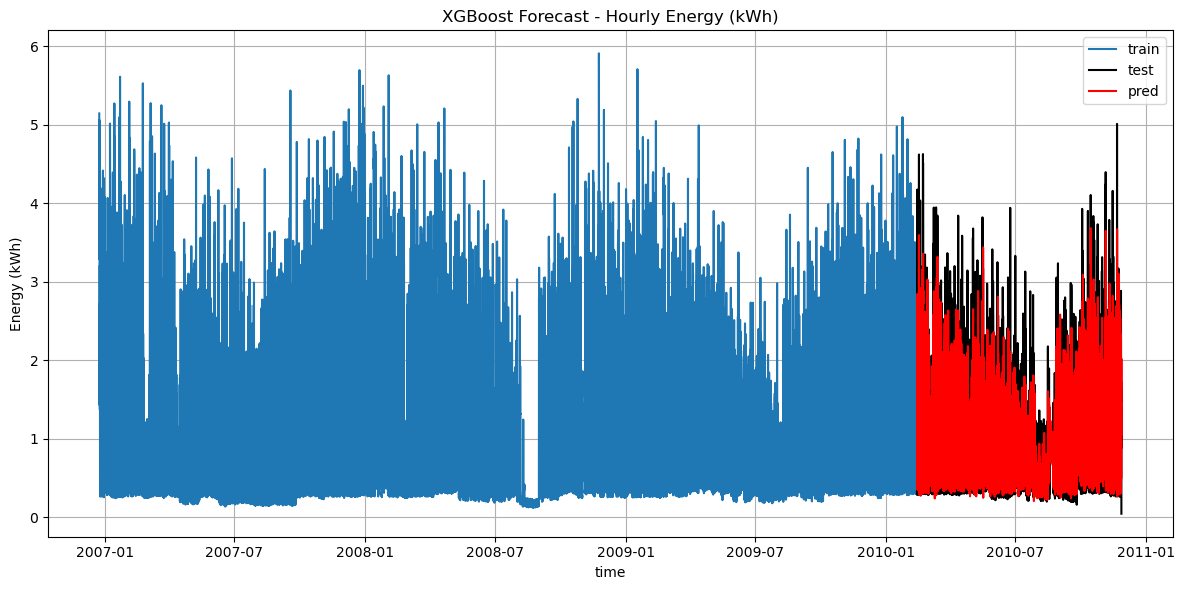

Global_intensity_lag_1     0.545790
lag_1                      0.053777
roll_std_24                0.029496
hour                       0.024417
Sub_metering_1_lag_1       0.024205
lag_168                    0.022798
Sub_metering_3_lag_1       0.022126
Global_intensity_lag_24    0.017444
Global_intensity_roll24    0.016705
Sub_metering_2_lag_1       0.016641
lag_2                      0.013824
roll_mean_24               0.013582
Sub_metering_1_roll24      0.011925
Voltage_lag_24             0.011837
Sub_metering_2_roll24      0.011747
dtype: float32


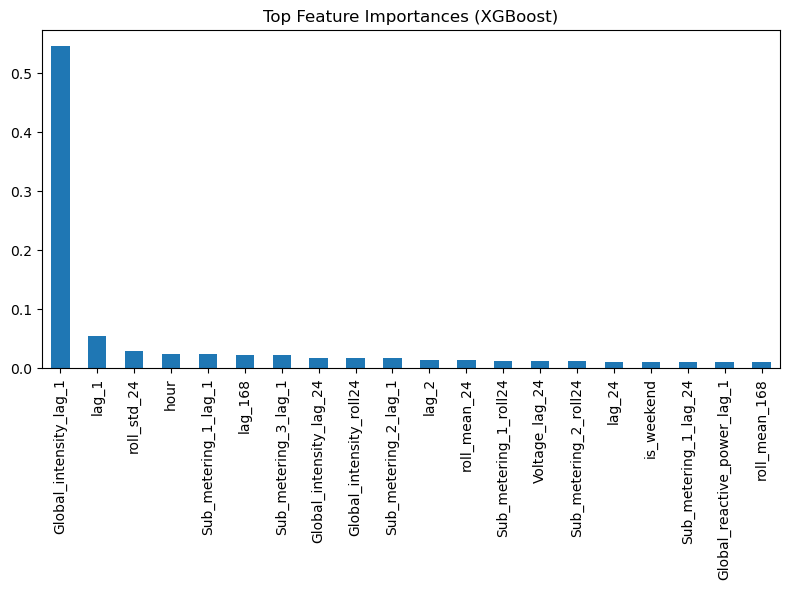

In [32]:
# XGBoost on hourly energy_kwh (uses cleaned 'hourly' df)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    from xgboost import XGBRegressor
except ImportError as e:
    raise ImportError("xgboost not installed. Run: pip install xgboost") from e
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# target = energy_kwh
target_col = 'energy_kwh'
y = hourly[target_col].asfreq('h').astype(float)
print("missing values:", y.isna().sum())

# time features
feat = pd.DataFrame(index=y.index)
feat['hour'] = feat.index.hour
feat['dow'] = feat.index.dayofweek
feat['month'] = feat.index.month
feat['is_weekend'] = (feat['dow'] >= 5).astype(int)

# lags of target
for k in [1, 2, 3, 24, 48, 168]:  # 1/2/3h, 1/2day, 1week
    feat[f'lag_{k}'] = y.shift(k)

# rolling stats of target
feat['roll_mean_24']  = y.rolling(24).mean()
feat['roll_std_24']   = y.rolling(24).std()
feat['roll_mean_168'] = y.rolling(168).mean()
feat['roll_std_168']  = y.rolling(168).std()

# optional exogenous (past-only)
exo_cols = ['Global_reactive_power','Voltage','Global_intensity',
            'Sub_metering_1','Sub_metering_2','Sub_metering_3']
for col in exo_cols:
    if col in hourly.columns:
        s = hourly[col].asfreq('h').astype(float)
        feat[f'{col}_lag_1']  = s.shift(1)
        feat[f'{col}_lag_24'] = s.shift(24)
        feat[f'{col}_roll24'] = s.rolling(24).mean()

# dataset
data = pd.concat([y.rename('y'), feat], axis=1).dropna()
split = int(len(data) * 0.8)
train, test = data.iloc[:split], data.iloc[split:]
X_train, y_train = train.drop(columns=['y']), train['y']
X_test,  y_test  = test.drop(columns=['y']),  test['y']
print("train shape:", X_train.shape, " test shape:", X_test.shape)

# model
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

# predict + metrics
y_pred = xgb.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = (np.abs((y_test - y_pred)/y_test.replace(0, np.nan))).mean() * 100
r2   = r2_score(y_test, y_pred)
print(f"XGBoost → MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%  R²={r2:.4f}")

# plot
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='train')
plt.plot(y_test.index,  y_test,  label='test', color='black')
plt.plot(y_test.index,  y_pred,  label='pred', color='red')
plt.title('XGBoost Forecast - Hourly Energy (kWh)')
plt.xlabel('time'); plt.ylabel('Energy (kWh)')
plt.legend(); plt.tight_layout(); plt.grid(True); plt.show()

# top features
importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(importances.head(15))
plt.figure(figsize=(8,6))
importances.head(20).plot(kind='bar')
plt.title('Top Feature Importances (XGBoost)')
plt.tight_layout(); plt.show()

### Introduction for Top Feature Importances
**Training set (80%)**: Historical energy consumption data from 2006 to 2009.  
**Test set (20%)**: The last portion of the dataset, covering the period from 2009 to 2010.

The model focuses primarily on **recent energy consumption** and **current intensity**, followed by short-term fluctuations and time-based features.  
This indicates that power consumption exhibits strong **temporal dependence** and **short-term memory**.

- **GlobalIntensity_lag_1** contributes over **50%**, highlighting that “current intensity of the previous hour” is the most critical predictor.  
- **lag_1** and **roll_std_24** are also important, representing recent fluctuations and the previous day’s variation.  
- **Hour** and **Sub_metering_1_lag_1** capture **daily cycle effects** such as morning and evening peaks.


## Evaluation Metrics

The model effectively captured the **downward trend** in overall energy consumption (notably from late 2009 to 2010).  
Local fluctuations were smoothed compared to the actual values, meaning XGBoost reduced extreme noise but remained responsive to short-term variations.

| Metric | Interpretation |
|:--------|:----------------|
| **R² = 0.6480** | The model explains about 65% of the variance, capturing general patterns and seasonality but missing some complex dynamics. |
| **MAE = 0.3027** | The average prediction error is about **0.3 kWh**, showing a noticeable but acceptable deviation. |
| **RMSE = 0.4307** | Indicates occasional large deviations, especially in volatile periods. |
| **MAPE = 40.19%** | Suggests higher relative errors during low-consumption periods. |

Overall, XGBoost performs well in modeling **general consumption patterns and seasonality**, though its precision declines slightly under irregular or high-variance conditions.


### Future Improvements

1. **Parameter Optimization**  
   Model performance can be enhanced through **hyperparameter tuning**, optimizing learning rate, tree depth, and regularization terms to improve both accuracy and stability.

2. **Hybrid Modeling**  
   Combining SARIMA and XGBoost (SARIMA + XGB) can leverage the advantages of **linear (trend) and nonlinear (interaction)** modeling, thus improving **forecasting robustness** in complex time-series data.


*In summary, XGBoost captures key temporal and cyclical characteristics in household energy usage, providing interpretable and actionable insights for energy management and prediction.*

# Next Steps

1. **Model Enhancement**
   
\vspace{-0.5em}

* Fine-tune SARIMA hyperparameters using grid search to improve forecasting accuracy.<br>
* Explore additional machine learning models such as LSTM to capture nonlinear and long-term seasonal patterns.<br>
* Compare model performance under different evaluation periods (daily, weekly, monthly).<br>

2. **Feature Engineering**

\vspace{-0.5em}

* Incorporate additional time-based features such as holiday indicators and temperature data.<br>
* Test interaction features (e.g., power × day of week) to improve explainability of energy consumption trends.<br>

3. **Model Interpretation**

\vspace{-0.5em}


* Apply SHAP or feature importance analysis to interpret XGBoost results.<br>
* Identify which factors (e.g., Voltage, Sub_metering_3) most influence energy demand at different times.<br>

4. **Aggregation and Scenario Analysis**

\vspace{-0.5em}

* Extend the model from hourly to daily and monthly aggregation for long-term planning.<br>
* Simulate “what-if” scenarios such as high-load summer months or voltage fluctuations.<br>